In [1]:
import warnings ; warnings.filterwarnings('ignore')
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from IPython.display import display
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from itertools import cycle, count
from textwrap import wrap

import matplotlib
import subprocess
import os.path
import tempfile
import random
import base64
import pprint
import glob
import time
import json
import sys
import gym
import io
import os
import gc

from gym import wrappers
from subprocess import check_output
from IPython.display import HTML

from zoo.value_based_agents import DQN, FCQ, DDQN
from zoo.exploration_strategies import *
from zoo.utils import *
from zoo.replay_buffers import *

SEEDS = (12, 34, 56)

%matplotlib inline

In [2]:
plt.style.use('fivethirtyeight')
params = {
    'figure.figsize': (15, 8),
    'font.size': 24,
    'legend.fontsize': 20,
    'axes.titlesize': 28,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
}
pylab.rcParams.update(params)
np.set_printoptions(suppress=True)

In [5]:
dqn_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in SEEDS:
    environment_settings = {
        'env_name': 'CartPole-v1',
        'gamma': 1.00,
        'max_minutes': 5,
        'max_episodes': 2500,
        'goal_mean_100_reward': 475
    }
    
    value_model_fn = lambda nS, nA: FCQ(nS, nA, hidden_dims=(512,128))
    value_optimizer_fn = lambda net, lr: optim.RMSprop(net.parameters(), lr=lr)
    value_optimizer_lr = 0.0005

    # training_strategy_fn = lambda: EGreedyStrategy(epsilon=0.5)
    # training_strategy_fn = lambda: EGreedyLinearStrategy(init_epsilon=1.0,
    #                                                      min_epsilon=0.3, 
    #                                                      max_steps=20000)
    # training_strategy_fn = lambda: SoftMaxStrategy(init_temp=1.0, 
    #                                                min_temp=0.1, 
    #                                                exploration_ratio=0.8, 
    #                                                max_steps=20000)
    training_strategy_fn = lambda: EGreedyExpStrategy(init_epsilon=1.0,  
                                                      min_epsilon=0.3, 
                                                      decay_steps=20000)
    evaluation_strategy_fn = lambda: GreedyStrategy()

    replay_buffer_fn = lambda: ReplayBuffer(m_size=50000, batch_size=64)
    n_warmup_batches = 5
    update_target_every_steps = 10

    env_name, gamma, max_minutes, \
    max_episodes, goal_mean_100_reward = environment_settings.values()
    agent = DQN(replay_buffer_fn,
                value_model_fn,
                value_optimizer_fn,
                value_optimizer_lr,
                training_strategy_fn,
                evaluation_strategy_fn,
                n_warmup_batches,
                update_target_every_steps)

    make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name)
    result, final_eval_score, training_time, wallclock_time = agent.train(
        make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward)
    dqn_results.append(result)
    if final_eval_score > best_eval_score:
        best_eval_score = final_eval_score
        best_agent = agent
dqn_results = np.array(dqn_results)
_ = BEEP()

el 00:00:00, ep 0000, ts 000016, ar 10 016.0±000.0, 100 016.0±000.0, ex 100 0.4±0.0, ev 019.0±000.0
el 00:01:00, ep 0142, ts 011109, ar 10 190.4±031.9, 100 099.1±074.6, ex 100 0.3±0.1, ev 269.5±109.7
el 00:02:02, ep 0185, ts 023596, ar 10 471.7±059.0, 100 201.5±129.2, ex 100 0.2±0.1, ev 334.9±111.9
el 00:03:04, ep 0212, ts 035563, ar 10 427.9±100.5, 100 291.4±152.9, ex 100 0.2±0.1, ev 391.1±118.2
el 00:04:06, ep 0234, ts 045469, ar 10 452.3±143.1, 100 358.9±147.8, ex 100 0.2±0.0, ev 432.8±105.4
el 00:05:03, ep 0252, ts 053772, ar 10 460.3±119.1, 100 406.7±136.6, ex 100 0.2±0.0, ev 469.3±077.2
--> reached_max_minutes ✕
Training complete.
Final evaluation score 500.00±0.00 in 264.14s training time, 333.67s wall-clock time.

el 00:00:00, ep 0000, ts 000034, ar 10 034.0±000.0, 100 034.0±000.0, ex 100 0.6±0.0, ev 008.0±000.0
el 00:01:00, ep 0134, ts 009279, ar 10 155.5±077.3, 100 083.5±073.7, ex 100 0.4±0.1, ev 251.3±099.1
el 00:02:01, ep 0175, ts 020046, ar 10 280.0±037.2, 100 175.9±109.9,

In [4]:
ddqn_results = []
ddqn_agents, best_ddqn_agent_key, best_eval_score = {}, None, float('-inf')
for seed in SEEDS:
    environment_settings = {
        'env_name': 'CartPole-v1',
        'gamma': 1.00,
        'max_minutes': 5,
        'max_episodes': 2500,
        'goal_mean_100_reward': 475
    }

    value_model_fn = lambda nS, nA: FCQ(nS, nA, hidden_dims=(512,128))
    value_optimizer_fn = lambda net, lr: optim.RMSprop(net.parameters(), lr=lr)
    value_optimizer_lr = 0.0005
    max_gradient_norm = float('inf')

    training_strategy_fn = lambda: EGreedyExpStrategy(init_epsilon=1.0,  
                                                      min_epsilon=0.3, 
                                                      decay_steps=20000)
    evaluation_strategy_fn = lambda: GreedyStrategy()

    replay_buffer_fn = lambda: ReplayBuffer(m_size=50000, batch_size=64)
    n_warmup_batches = 5
    update_target_every_steps = 10
    
    env_name, gamma, max_minutes, \
    max_episodes, goal_mean_100_reward = environment_settings.values()
    agent = DDQN(replay_buffer_fn, 
                 value_model_fn, 
                 value_optimizer_fn, 
                 value_optimizer_lr,
                 max_gradient_norm,
                 training_strategy_fn,
                 evaluation_strategy_fn,
                 n_warmup_batches,
                 update_target_every_steps)

    make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name)
    result, final_eval_score, training_time, wallclock_time = agent.train(
        make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward)
    ddqn_results.append(result)
    ddqn_agents[seed] = agent
    if final_eval_score > best_eval_score:
        best_eval_score = final_eval_score
        best_ddqn_agent_key = seed
ddqn_results = np.array(ddqn_results)
_ = BEEP()

el 00:00:00, ep 0000, ts 000016, ar 10 016.0±000.0, 100 016.0±000.0, ex 100 0.4±0.0, ev 019.0±000.0
el 00:01:00, ep 0124, ts 008751, ar 10 191.1±137.0, 100 081.1±084.4, ex 100 0.4±0.1, ev 249.6±137.1
el 00:02:01, ep 0163, ts 018434, ar 10 223.5±094.3, 100 162.3±119.6, ex 100 0.3±0.1, ev 327.3±106.7
el 00:03:04, ep 0196, ts 028088, ar 10 401.8±107.6, 100 240.7±119.9, ex 100 0.2±0.1, ev 367.6±102.6
el 00:04:04, ep 0218, ts 036948, ar 10 401.8±166.2, 100 294.8±137.8, ex 100 0.2±0.0, ev 397.9±105.0
el 00:05:02, ep 0236, ts 045470, ar 10 488.6±034.2, 100 337.8±143.5, ex 100 0.2±0.0, ev 425.9±099.0
--> reached_max_minutes ✕
Training complete.
Final evaluation score 500.00±0.00 in 265.23s training time, 325.93s wall-clock time.

el 00:00:00, ep 0000, ts 000034, ar 10 034.0±000.0, 100 034.0±000.0, ex 100 0.6±0.0, ev 008.0±000.0
el 00:01:00, ep 0118, ts 008672, ar 10 213.7±080.8, 100 081.8±082.2, ex 100 0.4±0.1, ev 221.9±126.2
el 00:02:02, ep 0158, ts 017915, ar 10 255.9±059.2, 100 162.6±100.5,

In [8]:
dqn_max_t, dqn_max_r, dqn_max_s, \
    dqn_max_sec, dqn_max_rt = np.max(dqn_results, axis=0).T
dqn_min_t, dqn_min_r, dqn_min_s, \
    dqn_min_sec, dqn_min_rt = np.min(dqn_results, axis=0).T
dqn_mean_t, dqn_mean_r, dqn_mean_s, \
    dqn_mean_sec, dqn_mean_rt = np.mean(dqn_results, axis=0).T
dqn_x = np.arange(np.max((len(dqn_mean_s), len(nfq_mean_s))))

In [9]:
ddqn_max_t, ddqn_max_r, ddqn_max_s, ddqn_max_sec, ddqn_max_rt = np.max(ddqn_results, axis=0).T
ddqn_min_t, ddqn_min_r, ddqn_min_s, ddqn_min_sec, ddqn_min_rt = np.min(ddqn_results, axis=0).T
ddqn_mean_t, ddqn_mean_r, ddqn_mean_s, ddqn_mean_sec, ddqn_mean_rt = np.mean(ddqn_results, axis=0).T
ddqn_x = np.arange(np.max((len(ddqn_mean_s), len(dqn_mean_s))))

NameError: name 'dqn_x' is not defined

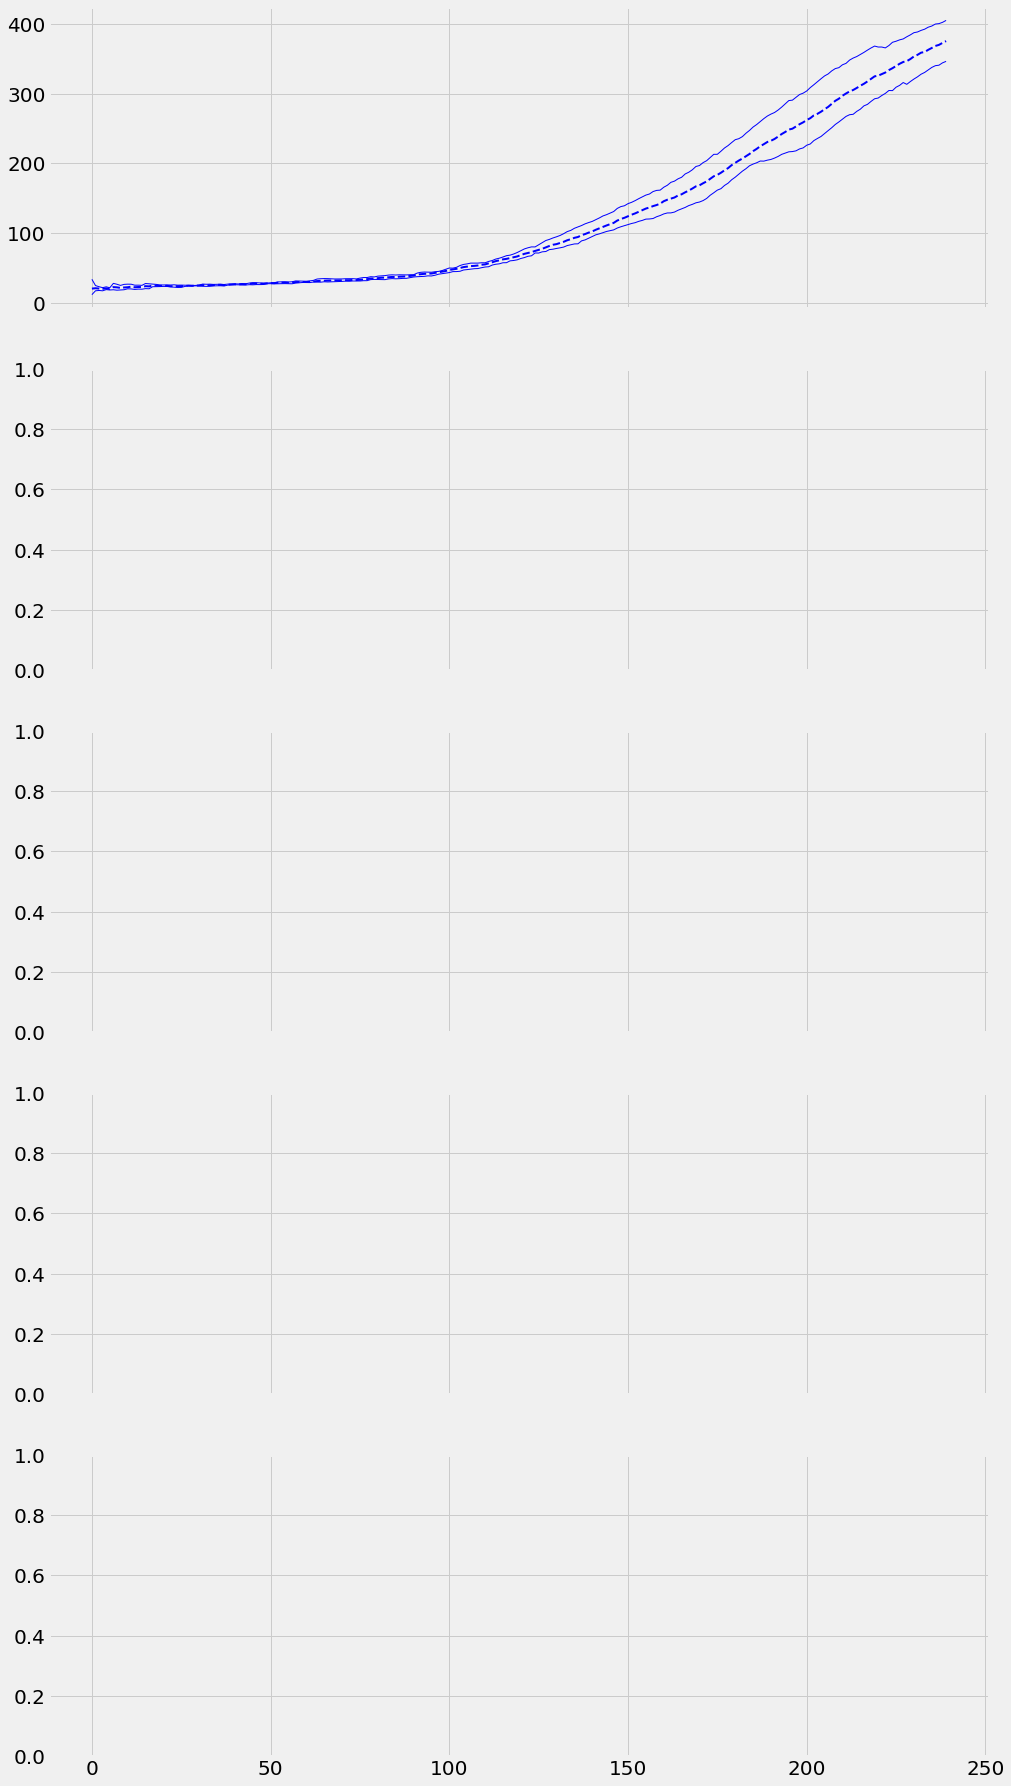

In [10]:
fig, axs = plt.subplots(5, 1, figsize=(15,30), sharey=False, sharex=True)

# DQN
axs[0].plot(dqn_max_r, 'b', linewidth=1)
axs[0].plot(dqn_min_r, 'b', linewidth=1)
axs[0].plot(dqn_mean_r, 'b--', label='DQN', linewidth=2)
axs[0].fill_between(dqn_x, dqn_min_r, dqn_max_r, facecolor='b', alpha=0.3)

axs[1].plot(dqn_max_s, 'b', linewidth=1)
axs[1].plot(dqn_min_s, 'b', linewidth=1)
axs[1].plot(dqn_mean_s, 'b--', label='DQN', linewidth=2)
axs[1].fill_between(dqn_x, dqn_min_s, dqn_max_s, facecolor='b', alpha=0.3)

axs[2].plot(dqn_max_t, 'b', linewidth=1)
axs[2].plot(dqn_min_t, 'b', linewidth=1)
axs[2].plot(dqn_mean_t, 'b--', label='DQN', linewidth=2)
axs[2].fill_between(dqn_x, dqn_min_t, dqn_max_t, facecolor='b', alpha=0.3)

axs[3].plot(dqn_max_sec, 'b', linewidth=1)
axs[3].plot(dqn_min_sec, 'b', linewidth=1)
axs[3].plot(dqn_mean_sec, 'b--', label='DQN', linewidth=2)
axs[3].fill_between(dqn_x, dqn_min_sec, dqn_max_sec, facecolor='b', alpha=0.3)

axs[4].plot(dqn_max_rt, 'b', linewidth=1)
axs[4].plot(dqn_min_rt, 'b', linewidth=1)
axs[4].plot(dqn_mean_rt, 'b--', label='DQN', linewidth=2)
axs[4].fill_between(dqn_x, dqn_min_rt, dqn_max_rt, facecolor='b', alpha=0.3)

# DDQN
axs[0].plot(ddqn_max_r, 'g', linewidth=1)
axs[0].plot(ddqn_min_r, 'g', linewidth=1)
axs[0].plot(ddqn_mean_r, 'g-.', label='DDQN', linewidth=2)
axs[0].fill_between(ddqn_x, ddqn_min_r, ddqn_max_r, facecolor='g', alpha=0.3)

axs[1].plot(ddqn_max_s, 'g', linewidth=1)
axs[1].plot(ddqn_min_s, 'g', linewidth=1)
axs[1].plot(ddqn_mean_s, 'g-.', label='DDQN', linewidth=2)
axs[1].fill_between(ddqn_x, ddqn_min_s, ddqn_max_s, facecolor='g', alpha=0.3)

axs[2].plot(ddqn_max_t, 'g', linewidth=1)
axs[2].plot(ddqn_min_t, 'g', linewidth=1)
axs[2].plot(ddqn_mean_t, 'g-.', label='DDQN', linewidth=2)
axs[2].fill_between(ddqn_x, ddqn_min_t, ddqn_max_t, facecolor='g', alpha=0.3)

axs[3].plot(ddqn_max_sec, 'g', linewidth=1)
axs[3].plot(ddqn_min_sec, 'g', linewidth=1)
axs[3].plot(ddqn_mean_sec, 'g-.', label='DDQN', linewidth=2)
axs[3].fill_between(ddqn_x, ddqn_min_sec, ddqn_max_sec, facecolor='g', alpha=0.3)

axs[4].plot(ddqn_max_rt, 'g', linewidth=1)
axs[4].plot(ddqn_min_rt, 'g', linewidth=1)
axs[4].plot(ddqn_mean_rt, 'g-.', label='DDQN', linewidth=2)
axs[4].fill_between(ddqn_x, ddqn_min_rt, ddqn_max_rt, facecolor='g', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
axs[2].set_title('Total Steps')
axs[3].set_title('Training Time')
axs[4].set_title('Wall-clock Time')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()